# Lab: Transfer Learning with MobileNetV2

In this lab work, you will use a pre-trained MobileNetV2 to build a binary classifier (with images of Alpaca/Not Alpaca animal). 
MobileNetV2, was designed to provide fast and computationally efficient performance. It is pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

<img src="https://github.com/renanaferreira/CAA-repository/blob/main/Lab7/images/alpaca.png?raw=true" style="width:300px;height:220px;">


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored
import os

import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import concatenate, Conv2DTranspose
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

### Utils functions

In [1]:
# Compare the two inputs
def comparator(learner, instructor):
    for a, b in zip(learner, instructor):
        if tuple(a) != tuple(b):
            print(colored("Test failed", attrs=['bold']),
                  "\n Expected value \n\n", colored(f"{b}", "green"), 
                  "\n\n does not match the input value: \n\n", 
                  colored(f"{a}", "red"))
            raise AssertionError("Error in test") 
    print(colored("All tests passed!", "green"))

# extracts the description of a given model
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
            descriptors.append(layer.strides)
            descriptors.append(layer.padding)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        if (type(layer) == ZeroPadding2D):
            descriptors.append(layer.padding)
        if (type(layer) == Dense):
            descriptors.append(layer.activation.__name__)
        result.append(descriptors)
    return result

### Training and Validation data Sets
Keras function `image_data_set_from_directory()` reads from the directory and create training and validation datasets. 
The seed need to be the same, so the training and validation sets don't overlap.  

If the directory structure is:

main_directory/

...class_a/ (in our case directory alpaca => 142 images )

...class_b/  (in our case directory nonalpaca => 185 images )

Then calling `image_data_set_from_directory(main_directory, labels='inferred')` will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

Supported image formats: jpeg, png, bmp, gif. Animated gifs are truncated to the first frame.

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
SHUFFLE=True
SEED=42
directory = "/kaggle/input/alpaca-detection/dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=SHUFFLE,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=SEED)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=SHUFFLE,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=SEED)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


<img src="https://github.com/renanaferreira/CAA-repository/blob/main/Lab7/images/f2.jpg?raw=true" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'> <b>Fig. 1</b> </u><font color='purple'>  : <b>Some samples</b> <br> </center></caption>

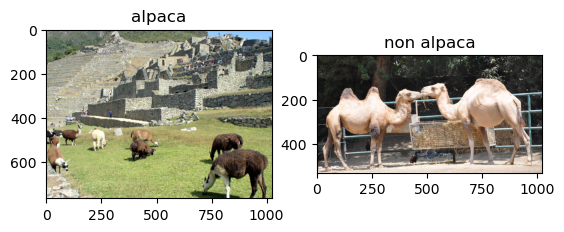

In [6]:
# Try to plot some images as in Fig. 1. 

IMAGE_DIR1 = "/kaggle/input/alpaca-detection/dataset/alpaca"
IMAGE_DIR2 = "/kaggle/input/alpaca-detection/dataset/not alpaca"

plt.subplot(1, 2, 1)
img = plt.imread(os.path.join(IMAGE_DIR1, '0a2ea8f93b4cb30a.jpg'))
plt.imshow(img)
plt.title("alpaca")

plt.subplot(1, 2, 2)
img = plt.imread(os.path.join(IMAGE_DIR2, '039dfd67a8e053b8.jpg'))
plt.imshow(img)
plt.title("non alpaca")

plt.show()

In [7]:
class_names = train_dataset.class_names

##  Preprocess and Augment Training Data

`dataset.prefetch` is an important step in data preprocessing. 

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

`tf.data.experimental.AUTOTUNE` will choose the number of elements to prefetch automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  #AUTOTUNE= -1 ???
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

### Data_augmenter

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras offers a straightforward method for data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.

Read the official docs for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).

The function *data_augmenter* (for data augmentation) uses `Sequential` keras model composed of 2 layers:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [16]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))

    
    return data_augmentation

The training images are augmented with simple transformations: see 9 variations from one image.

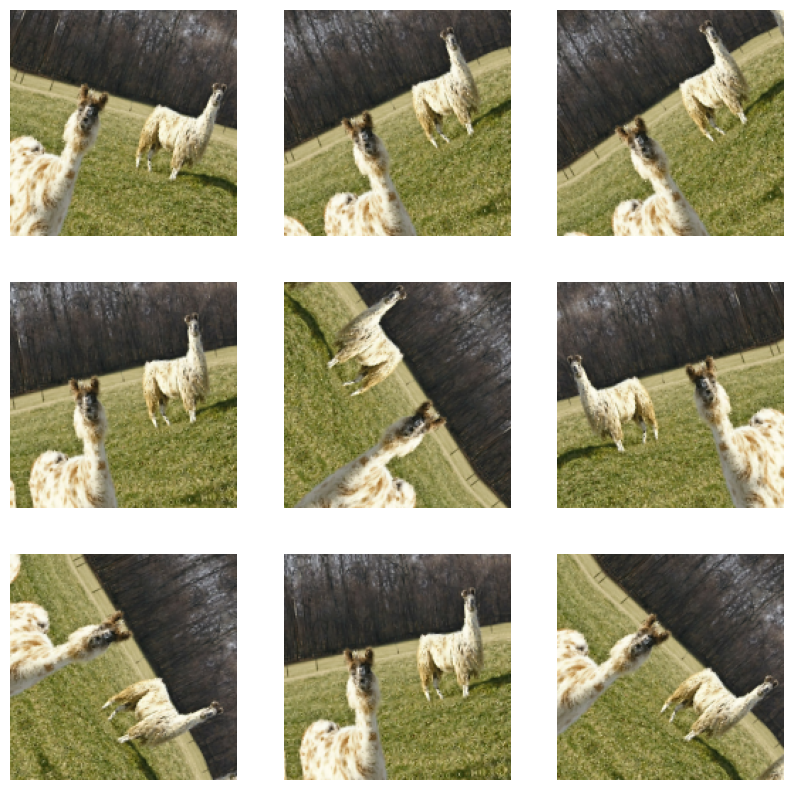

In [17]:
#Call data_augmenter() to create the augmentation object here

data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## Using MobileNetV2 for Transfer Learning 

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications.MobileNetV2 is efficient for classification, object detection and image segmentation tasks and has 3 unique characteristics:

*   Depthwise separable convolutions deal with both spatial and depth (number of channels) dimensions and provide lightweight feature filtering and creation.
*   Input and output bottlenecks that preserve important information on either end of the block
*   Shortcut connections between bottleneck layers


### MobileNetV2 Convolutional Building Block
<img src="https://github.com/renanaferreira/CAA-repository/blob/main/Lab7/images/mobilenetv2.png?raw=true" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'> <b>Fig. 2</b> </u><font color='purple'>  : <b>MobileNetV2 Architecture</b> <br> This diagram was inspired by the original seen <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">here</a>.</center></caption>

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps: 

1. Depthwise convolution is the first step that computes an intermediate result by convolving on each of the channels independently. 

2. Pointwise convolution is the second step that is Shape of the depthwise convolution X Number of filters.

Each block consists of a residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space. 

The shortcut connections (similar to the ones in traditional residual networks) serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers. 

In [25]:
#Reuse the normalization values [-1,1] with which MobileNetV2 was pre-trained

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
print(preprocess_input)

<function preprocess_input at 0x7f74ae247170>


Load the pretrained MobileNetV2 with the weights from ImageNet dataset by specifying `weights='imagenet'`. 

In [26]:
IMG_SHAPE = IMG_SIZE + (3,)  #(160,160,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

Model summary show all model's layers, the output shapes, the total number of parameters, trainable and non-trainable. 
The DepthwiseConv2D and SeparableConv2D layers are part of the intermediate expansion layer. 

In [21]:
# compute the model summary 
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [24]:
#How many layers has the model 
nb_layers = len(base_model.layers)
print(nb_layers)

#Get the names of the last 2 layers (called top layers),
#responsible for the predictions (classification) in the model. 
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)


156
global_average_pooling2d
predictions


Choose the first batch of images from the tensorflow dataset, and run it through the MobileNetV2 base model to test out the model predictions on those images. 

(32, 160, 160, 3)
(32,)
tf.Tensor(0, shape=(), dtype=int32)
(32, 1000)


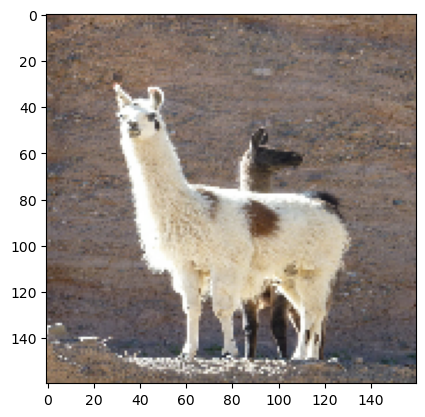

In [31]:
image_batch, label_batch = next(iter(train_dataset))

pred= base_model(image_batch)

# Get the dimensions of image_batch, label_batch, pred 
# What are their meanings ?

print(image_batch.shape)
print(label_batch.shape)
print(label_batch[1])
print(pred.shape)

#Try to plot one image from image_batch 

plt.imshow(image_batch[0]/255)

Now decode the predictions made by the model.

The predictions returned by the base model below follow the following format: i) class number, ii) human-readable label, iii) the probability of the image belonging to that class. top=2 means to return only the top two probabilities for that image.

In [32]:
base_model.trainable = False

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)


35363/35363 [==============================] - 0s 0us/step


[[('n04589890', 'window_screen', 0.43319005),
  ('n03733281', 'maze', 0.024245787)],
 [('n04589890', 'window_screen', 0.47466058),
  ('n04507155', 'umbrella', 0.033312198)],
 [('n03598930', 'jigsaw_puzzle', 0.48526806),
  ('n03733281', 'maze', 0.13003139)],
 [('n03598930', 'jigsaw_puzzle', 0.44012135),
  ('n04589890', 'window_screen', 0.24859624)],
 [('n04589890', 'window_screen', 0.15944827),
  ('n02098286', 'West_Highland_white_terrier', 0.11118382)],
 [('n04589890', 'window_screen', 0.6582595),
  ('n03347037', 'fire_screen', 0.06083732)],
 [('n04589890', 'window_screen', 0.26568446),
  ('n04590129', 'window_shade', 0.06962208)],
 [('n04589890', 'window_screen', 0.9507102),
  ('n03530642', 'honeycomb', 0.0024237372)],
 [('n03598930', 'jigsaw_puzzle', 0.15709195),
  ('n02085620', 'Chihuahua', 0.10329361)],
 [('n04589890', 'window_screen', 0.6745237),
  ('n03530642', 'honeycomb', 0.076599084)],
 [('n04507155', 'umbrella', 0.07484169),
  ('n03944341', 'pinwheel', 0.07235372)],
 [('n0359

As you see, none of the labels is "alpaca."
This is because MobileNet pretrained over ImageNet doesn't have labels for alpacas, so when you use the model, you get incorrectly classified images.

Now, you will delete the top layer, which contains the ImageNet labels, and create a new binary classification layer.

###  Layer Freezing and model retraining 

You will use the pretrained model to modify the classifier task so that it's able to recognize alpacas: 

1. Delete the top layer (the classification layer): 
    * Set `include_top` in `base_model` as False
2. Add a new top classification (prediction) layer: 
``Dense()``
3. Freeze the base model and train only the newly-created classifier layer: 
    * Set `base_model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False

### Alpaca_model

In [46]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of 
    # MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    '''
        
    #IMG_SIZE= (160, 160)
    input_shape = image_shape + (3,)
    
    #Load the base pretrained MobileNetV2 model. 
    #Set include_top as False
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
# data preprocessing using the same weights as the model was trained on
    x = preprocess_input(x) 
    
    # set training to False
    x = base_model(x, training=False) 
    
    # Add new Binary classification layer
    # use global average pooling to summarize the info in each channel
    x = GlobalMaxPooling2D()(x)
    
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.2)(x)
        
    # Add new Binary classification layer with one neuron
    prediction_layer = Dense(1, activation="sigmoid")
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [47]:
# Create the new alpaca_model with data_augmentation
model2 = alpaca_model(IMG_SIZE, data_augmenter())

## Get model summary, observe data augmentation layers 
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [48]:
# Compile model2, with Adam optimizer & suggested base_learning_rate

base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


#Different results when using loss='binary_crossentropy' !!!

In [49]:
#Fit the model for 5 epochs
initial_epochs = 5

history = model2.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs
)

Epoch 1/5
9/9 [==============================] - 13s 695ms/step - loss: 4.0045 - accuracy: 0.5153 - val_loss: 0.7308 - val_accuracy: 0.8154
Epoch 2/5
9/9 [==============================] - 6s 572ms/step - loss: 1.3525 - accuracy: 0.7481 - val_loss: 1.8847 - val_accuracy: 0.7077
Epoch 3/5
9/9 [==============================] - 6s 550ms/step - loss: 1.0698 - accuracy: 0.7939 - val_loss: 0.2495 - val_accuracy: 0.8923
Epoch 4/5
9/9 [==============================] - 6s 545ms/step - loss: 0.6016 - accuracy: 0.8511 - val_loss: 0.2525 - val_accuracy: 0.9231
Epoch 5/5
9/9 [==============================] - 6s 559ms/step - loss: 0.5229 - accuracy: 0.8702 - val_loss: 0.1066 - val_accuracy: 0.9385


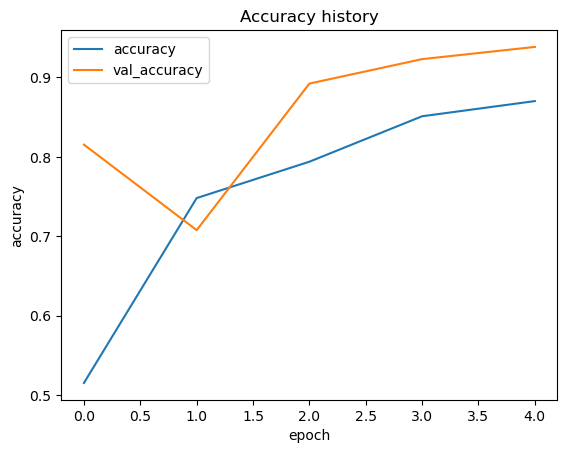

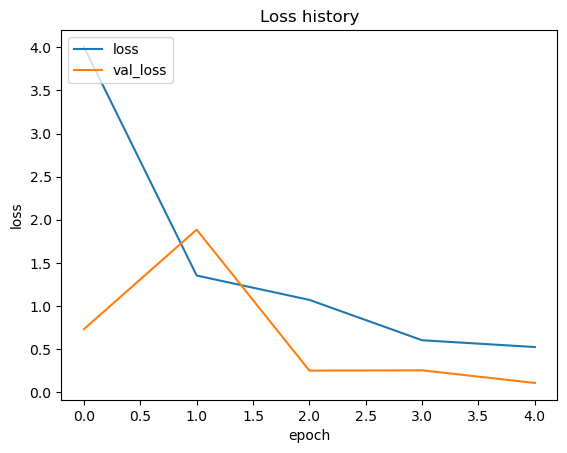

In [55]:
# Plot training & validation accuracy and loss curves 
# print(history.history)

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(acc)
plt.plot(val_acc)
plt.title("Accuracy history")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

loss = history.history["loss"] 
val_loss = history.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)
plt.title("Loss history")
plt.legend(["loss", "val_loss"], loc="upper left")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


###  Fine-tuning the Model

Try fine-tuning the model to improve accuracy. The way you achieve this is by unfreezing the layers at the end of the network, and then re-training the model on the final layers with a very low learning rate. Adapting the learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth. 

To achieve this, unfreeze the final layers and re-run the optimizer with a smaller learning rate, keep all other layers frozen.

Where the final layers actually begin is a bit arbitrary, so play around with this number. The important takeaway is that the later layers are the part of the network that contain the fine details (pointy ears, hairy tails) that are more specific to the particular problem. 

In [57]:
# unfreeze the base model 
base_model.trainable = True

# How many layers are in the base model ?
print(f"Number of layers in the base model: {len(base_model.layers)} ")


# Choose to fine-tune from this layer onwards
fine_tune_at = 126

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = None

    
#Compile model2, with Adam optimizer and
# learning rate = 0.1*base_learning_rate

optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
model2.compile(optimizer= optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


Number of layers in the base model: 156 


In [58]:
#Fit the model for another few epochs, and see if the accuracy improved.

fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 15s 840ms/step - loss: 2.8680 - accuracy: 0.6908 - val_loss: 1.5450 - val_accuracy: 0.7538
Epoch 6/10
9/9 [==============================] - 6s 534ms/step - loss: 1.3388 - accuracy: 0.8321 - val_loss: 0.8972 - val_accuracy: 0.8308
Epoch 7/10
9/9 [==============================] - 6s 548ms/step - loss: 1.3768 - accuracy: 0.8206 - val_loss: 0.4387 - val_accuracy: 0.9077
Epoch 8/10
9/9 [==============================] - 6s 539ms/step - loss: 0.9051 - accuracy: 0.8664 - val_loss: 0.0607 - val_accuracy: 0.9692
Epoch 9/10
9/9 [==============================] - 6s 551ms/step - loss: 0.7859 - accuracy: 0.8779 - val_loss: 0.7789 - val_accuracy: 0.8308
Epoch 10/10
9/9 [==============================] - 6s 575ms/step - loss: 0.6751 - accuracy: 0.8664 - val_loss: 0.0570 - val_accuracy: 0.9846


Plot training & validation accuracy and loss curves. You are expected to get something similar as in Fig. 3

<img src="https://github.com/renanaferreira/CAA-repository/blob/main/Lab7/images/f3.jpg?raw=true" style="width:400px;height:300px;">
<caption><center> <u> <font color='purple'> <b>Fig. 3</b> </u><font color='purple'>  : <b>Some samples</b> <br> </center></caption>

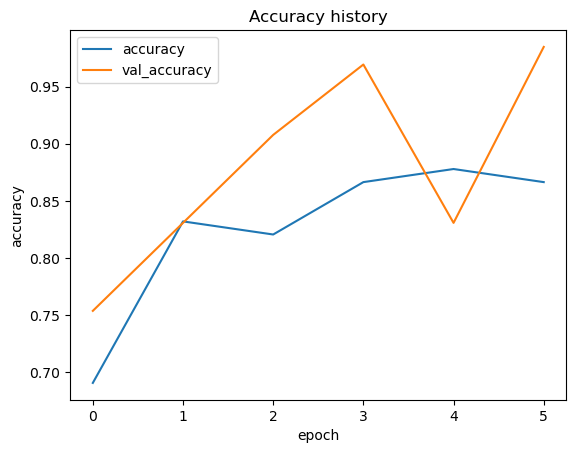

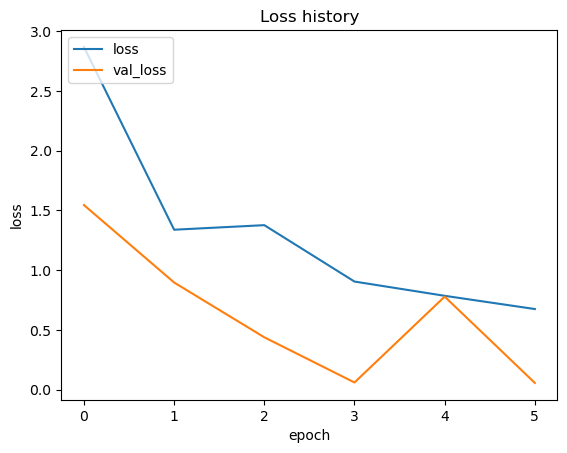

In [61]:
acc = history_fine.history["accuracy"]
val_acc = history_fine.history["val_accuracy"]

plt.plot(acc)
plt.plot(val_acc)
plt.title("Accuracy history")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

loss = history_fine.history["loss"] 
val_loss = history_fine.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)
plt.title("Loss history")
plt.legend(["loss", "val_loss"], loc="upper left")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()